# Типичный А/В тест продуктового аналитика:

На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле ты найдешь сырые данные по результатам эксперимента (user_id), тип выборки (variant_name) и доход, принесенный пользователем (revenue).
Проанализируй результаты эксперимента и напиши свои рекомендации менеджеру.
(приложи скрипт с помощью которого анализировал данные, желательно файл .ipynb на python)


<b>Гипотеза:</b> нововведение в тестовой группе увеличит доход. 

Описание данных: 
- user_id - id пользователя 
- variant_name - тип выборки 
- revenue - доход от пользователя 

Группы: variant - с изменением, control - без изменения 


<b>Ключевые метрики: </b>
- <b>ARPU</b> = доход / уникальные юзеры (Посмотрим увеличился ли доход с пользователя в целом)

<b>Вспомогательные метрики</b>
- <b>ARPPU</b> = доход / покупающие уникальные юзеры (Посмотрим стали ли пользователи больше покупать)
- <b>CR в уникальный заказ</b> = покупающие уникальные юзеры / уникальные юзеры (Посмотрим привлекли ли мы новую аудиторию к покупкам)
- Было бы еще неплохо посмотреть на частоту покупок на одного пользователя, но у нас нет идентификатора заказа в датасете


In [360]:
import pandas as pd


## Предобработка данных 

Проверим таблицу на: 
- Пропуски 
- Тип данных 
- Дубликаты

In [361]:
# -- AB_Test_Results

df = pd.read_csv('AB_Test_Results.csv')
df.columns = ['user_id', 'var', 'revenue']
display(df.sort_values('user_id').head(20))
display(df.info())
print('Уникальные id пользователей')
display(df['user_id'].unique())
print('Уникальные варианты')
display(df['var'].unique())
print('Уникальные доходы')
display(df['revenue'].unique())

print()
print('Юзеры, у которых есть и тестовая и контрольная версии')
user_groupped = df.groupby('user_id')['var'].nunique().reset_index().rename(columns = {'var': 'unique_vars_cnt'})
users_for_remove = user_groupped[user_groupped['unique_vars_cnt']>=2]
display(users_for_remove)




,user_id,var,revenue
2406,2,control,"0,00"
3479,2,control,"0,00"
7076,2,control,"0,00"
7409,3,variant,"0,00"
4145,3,variant,"0,00"
5377,3,control,"0,00"
9077,4,variant,"0,00"
9155,5,variant,"0,00"
7720,6,variant,"0,00"
3920,9,variant,"0,00"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  10000 non-null  int64 
 1   var      10000 non-null  object
 2   revenue  10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


None

Уникальные id пользователей


array([ 737, 2423, 9411, ...,  502, 7741, 9468])

Уникальные варианты


array(['variant', 'control'], dtype=object)

Уникальные доходы


array(['0,00', '2,15', '3,25', '4,27', '1,75', '2,99', '9,91', '1,26',
       '10,63', '17,05', '2,17', '1,25', '5,45', '4,87', '3,75', '17,87',
       '196,01', '11,98', '0,50', '1,56', '1,51', '3,99', '1,50', '3,98',
       '1,36', '3,24', '0,04', '23,04', '2,01', '1,00', '8,70', '10,82',
       '4,95', '1,01', '2,72', '0,02', '0,58', '2,00', '17,08', '2,27',
       '2,14', '8,66', '2,19', '14,24', '1,52', '0,86', '1,77', '0,60',
       '2,02', '2,70', '5,08', '4,33', '12,99', '2,16', '3,28', '3,97',
       '1,29', '5,02', '19,47', '18,56', '2,50', '3,00', '6,46', '3,83',
       '2,22', '3,79', '20,07', '58,63', '4,52', '9,99', '2,34', '2,95',
       '3,58', '0,84', '1,92', '10,67', '7,27', '7,58', '2,60', '0,90',
       '57,46', '6,35', '4,98', '29,32', '1,30', '5,98', '0,06', '1,99',
       '2,52', '1,23', '14,07', '25,98', '2,24', '4,37', '1,66', '41,53',
       '1,78', '0,23', '2,93', '14,17', '2,92'], dtype=object)


Юзеры, у которых есть и тестовая и контрольная версии


,user_id,unique_vars_cnt
1,3,2
6,10,2
11,18,2
15,25,2
23,40,2
...,...,...
6310,9978,2
6311,9979,2
6313,9982,2
6321,9996,2


1. Видим, что revenue в текстовом формате. Заменим запятую на точку и переведем во float. 
2. Пропущенных значений нет. 
3. Есть дубликаты user_id - у 1541 пользователей есть и тестовая и контрольная группа. Придется избавиться от этих пользователей, так как мы не знаем какая группа могла оказат влияние на пользователя. Такое может происходить из-за ошибок в распределении данных по вариантам аб теста или если пользователь каким-либо образом вручную изменил вариант отображения, возможно, это были коллеги когда тестировали функционал на бою или боты. 





In [362]:
# избавимся от лишних юзеров
df = df[~df['user_id'].isin(users_for_remove['user_id'])]
df



,user_id,var,revenue
0,737,variant,"0,00"
4,6174,variant,"0,00"
5,2380,variant,"0,00"
7,9168,control,"0,00"
9,7548,control,"0,00"
...,...,...,...
9993,2400,variant,"0,00"
9994,3129,control,"0,00"
9996,502,variant,"0,00"
9998,7741,control,"0,00"


In [363]:
# переведем revenue в float 
df['revenue'] = df['revenue'].apply(lambda x: x.replace(',', '.'))
df['revenue'] = df['revenue'].apply(lambda x: float(x))
display(df.info())
display(df)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6070 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  6070 non-null   int64  
 1   var      6070 non-null   object 
 2   revenue  6070 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 189.7+ KB


None

,user_id,var,revenue
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0
...,...,...,...
9993,2400,variant,0.0
9994,3129,control,0.0
9996,502,variant,0.0
9998,7741,control,0.0


In [364]:
# проагреггируем доход по каждому пользователю
df = df.groupby(['user_id', 'var'])['revenue'].sum().reset_index()
display(df)



,user_id,var,revenue
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4778,9990,variant,0.0
4779,9992,control,0.0
4780,9993,control,0.0
4781,9995,variant,0.0


Итоговая таблица готова. 

Теперь можно считать метрики. 

## Подсчет показателей

Сначла посчитаем абсолютные показатели: 
- users - пользователи 
- %GT - распределение по вариантам 
- paying_users - платящие пользователи 
- revenue - доход

In [365]:
# количество юзеров
res = df.groupby(['var']).agg({
    'user_id': 'nunique'
}).reset_index().rename(columns = {'user_id':'users'})

# распредение по группам 
res['%GT'] = (res['users']/res['users'].sum())*100

# Количество пользователей с покупкой
order_users =  df[df['revenue']>0].groupby('var')['user_id'].nunique().reset_index().rename(columns = {'user_id': 'paying_users'})
res = res.merge(order_users, on = 'var', how='inner')

# Доход 
revenue = df.groupby('var')['revenue'].sum().reset_index()
res = res.merge(revenue, on= 'var', how = 'inner')



res




,var,users,%GT,paying_users,revenue
0,control,2390,49.968639,54,470.56
1,variant,2393,50.031361,42,179.32


Посчитали абсолютные показатели. Видим, что пользователи равнрмерно распрежелены по группам, что позволяет нам провести стат тесты правильно. 


## Выбросы

Посмотрим на выбросы в revenue 


Выбросы в контрольной


<AxesSubplot:>

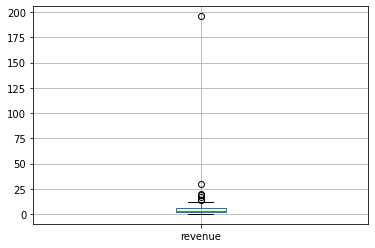

In [366]:
print('Выбросы в контрольной')
df[(df['var']=='control') & (df['revenue']>0)].boxplot(column='revenue')






Выбросы в контрольной


<AxesSubplot:>

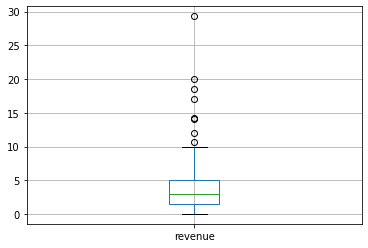

In [367]:
# избавимся от самого большого выброса и посмотрим на боксплот ближе
print('Выбросы в контрольной')
df[(df['var']=='control') & (df['revenue']>0) & (df['revenue']<50)].boxplot(column='revenue')



Выбросы в тестовой


<AxesSubplot:>

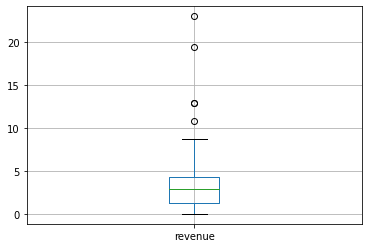

In [368]:
print('Выбросы в тестовой')
df[(df['var']=='variant') & (df['revenue']>0)].boxplot(column='revenue')



<b>Что мы видим: </b>
- Медианы в группах визуально отличаются не сильно
- В тестовой группе верхняя граница меньше чем в контрольной 
- 50% самых популярных значений в тестовой группе чуть меньше по доходу чем в контрольной (75 процентиль в тестовой < 5, в контрольной = 5)
- И в тестовой и в контрольной группах есть выбросы. В и в тестовой и в контрольной группе это показатели больше 10.

Что будем делать: 
- Денежные показатели будем тестировать двумя способами: с помощью <b>T-критерия</b> и <b>Теста Манна-Уитни</b>
- <b>Т-критерий</b> потестим среднее значение без учета выбросов, потому что средние значения чувствительны к выбросам. 
    - Для подсчета <b>ARPU</b> данных вполне достаточно, поэтому можем использовать этот тест с чистой совестью. 
    - Для <b>ARPPU</b> уже не сказать чтобы очень много, но в статистике считается, что если выборка > 30, то она достаточно большая для применения парметрических тестов, требующих, чтобы распределение среднего значения было нормальным (ЦПТ). Тем не менее, из-за количества данных мощность теста здесь будет низкая, поэтому здесь будем действовать осторожнее и обязательно будем смотреть на результаты теста Манна_Уитни, который не требует нормальности распределения и работающий на выборках с небольшим кол-вом данных.
- <b>Тест Манна-Уитни</b> проведем с выбросами, так как он не чувствителен к ним, ведь он сравнивает сами распределения данных. Этот тест менее мощный, чем Т-критерий. 
    - <b>ARPU</b> посмотрим с выбросами 
    - Хорошо подходит для <b>ARPPU</b>, так как в случае этой метрики у нас не так много данных 




## Считаем показатели без выбросов 
Выбросы в тестовой = revenue > 10
Выбросы в контрольной = revenue > 10

In [369]:
# создадим датафрейм без выбросов
df2 = df[df['revenue']<10]
display(df2)


,user_id,var,revenue
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4778,9990,variant,0.0
4779,9992,control,0.0
4780,9993,control,0.0
4781,9995,variant,0.0


In [370]:
# количество юзеров
res2 = df2.groupby(['var']).agg({
    'user_id': 'nunique'
}).reset_index().rename(columns = {'user_id':'unl_users'})

# распредение по группам 
res2['unl_%GT'] = (res2['unl_users']/res2['unl_users'].sum())*100

# Количество пользователей с покупкой
order_users2 =  df2[df2['revenue']>0].groupby('var')['user_id'].nunique().reset_index().rename(columns = {'user_id': 'unl_paying_users'})
res2 = res2.merge(order_users2, on = 'var', how='inner')

# Доход 
revenue2 = df2.groupby('var')['revenue'].sum().reset_index().rename(columns = {'revenue': 'unl_revenue'})
res2 = res2.merge(revenue2, on= 'var', how = 'inner')




In [371]:
print("С выбросами")
display(res)
print("Без выбросов")
display(res2)


С выбросами


,var,users,%GT,paying_users,revenue
0,control,2390,49.968639,54,470.56
1,variant,2393,50.031361,42,179.32


Без выбросов


,var,unl_users,unl_%GT,unl_paying_users,unl_revenue
0,control,2381,49.926609,45,138.63
1,variant,2388,50.073391,37,100.01


Данных без выбросов стало не сильно меньше, зато доход в контрольной версии стал значительно меньше.

## Подсчет метрик

<b>Ключевые метрики: </b>
- <b>ARPU</b> = доход / уникальные юзеры 

<b>Вспомогательные метрики: </b>
- <b>CR в уникальный заказ</b> = покупающие уникальные юзеры / уникальные юзеры
- <b>ARPPU</b> = доход / покупающие уникальные юзеры 





In [372]:
# Считаем метрики с выбросами
res['ARPU'] = res['revenue'] / res['users']
res['ARPPU'] = res['revenue'] / res['paying_users']
res['CR_order'] = (res['paying_users'] / res['users'])*100


In [373]:
# Считаем метрики без выбросов
res2['unl_ARPU'] = res2['unl_revenue'] / res2['unl_users']
res2['unl_ARPPU'] = res2['unl_revenue'] / res2['unl_paying_users']
res2['unl_CR_order'] = (res2['unl_paying_users'] / res2['unl_users'])*100


In [374]:
print('С выбросами')
display(res)
print('Без выбросов')
display(res2)


С выбросами


,var,users,%GT,paying_users,revenue,ARPU,ARPPU,CR_order
0,control,2390,49.968639,54,470.56,0.196887,8.714074,2.259414
1,variant,2393,50.031361,42,179.32,0.074935,4.269524,1.755119


Без выбросов


,var,unl_users,unl_%GT,unl_paying_users,unl_revenue,unl_ARPU,unl_ARPPU,unl_CR_order
0,control,2381,49.926609,45,138.63,0.058223,3.080667,1.889962
1,variant,2388,50.073391,37,100.01,0.041880,2.702973,1.549414


Получили две таблицы с данными с выбросами и без. 
В случае ARPU и ARPPU надежнее смотреть на данные без выбросаов. В случае CR в покупку смотрим на данные с выбросами, так как в пропорциях выбросов нет. 

In [375]:
res = res.merge(res2, how = 'inner', left_on='var', right_on='var')



In [376]:
res_abs = res[['var', 'users', 'unl_users', '%GT', 'unl_%GT', 'paying_users', 'unl_paying_users', 'revenue', 'unl_revenue']]
res_relative = res[['var', 'unl_ARPU', 'ARPU', 'unl_ARPPU', 'ARPPU', 'CR_order']]

res_abs_T = res_abs.T
res_abs_T.columns = res_abs_T.iloc[0]
res_abs_T = res_abs_T.iloc[1:]

res_relative = res_relative.T
res_relative.columns = res_relative.iloc[0]
res_relative = res_relative.iloc[1:]

res_relative['%_delta'] = (100/res_relative['control'])*res_relative['variant']-100


In [377]:
print('Абсолютные показатели')
display(res_abs_T)
print('Относительные показатели')
display(res_relative)



Абсолютные показатели


var,control,variant
users,2390,2393
unl_users,2381,2388
%GT,49.968639,50.031361
unl_%GT,49.926609,50.073391
paying_users,54,42
unl_paying_users,45,37
revenue,470.56,179.32
unl_revenue,138.63,100.01


Относительные показатели


var,control,variant,%_delta
unl_ARPU,0.058223,0.04188,-28.069798
ARPU,0.196887,0.074935,-61.939988
unl_ARPPU,3.080667,2.702973,-12.260129
ARPPU,8.714074,4.269524,-51.004275
CR_order,2.259414,1.755119,-22.319729


## Проверка на статистическую значимость

In [378]:
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from statsmodels.stats import weightstats
from datetime import datetime
import statsmodels.stats.weightstats as ws
import math 
import matplotlib.pyplot as plt


### ARPU

- H0: arpu_control = arpu_test
- H1: arpu_control > arpu_test

In [379]:

# Тест Манна_Уитни с выбросами
u_result_bill = stats.mannwhitneyu(df[df['var']=='control']['revenue'], df[df['var']=='variant']['revenue'], 
                              alternative='greater')

# Т-тест без выбросов 
t_result_bill = weightstats.ttest_ind(df2[df2['var']=='control']['revenue'], df2[df2['var']=='variant']['revenue'],
                     usevar='unequal', alternative='larger')

print(u_result_bill)
print('Ttest_indResult', t_result_bill[0], '{:.19f}'.format(t_result_bill[1]))


MannwhitneyuResult(statistic=2874161.0, pvalue=0.10524375041358902)
Ttest_indResult 1.1731071476713617 0.1204078089046024397


- H0: arpu_control = arpu_test
- H1: arpu_control != arpu_test

In [380]:
# Тест Манна_Уитни с выбросами
u_result_bill = stats.mannwhitneyu(df[df['var']=='control']['revenue'], df[df['var']=='variant']['revenue'], 
                              alternative='two-sided')

# Т-тест без выбросов 
t_result_bill = weightstats.ttest_ind(df2[df2['var']=='control']['revenue'], df2[df2['var']=='variant']['revenue'],
                     usevar='unequal', alternative='two-sided')

print(u_result_bill)
print('Ttest_indResult', t_result_bill[0], '{:.19f}'.format(t_result_bill[1]))





MannwhitneyuResult(statistic=2874161.0, pvalue=0.21048750082717804)
Ttest_indResult 1.1731071476713617 0.2408156178092048794


- H0: arpu_control = arpu_test
- H1: arpu_control > arpu_test
- a = 0.05
- T_p-value = 0.12
- MW_p-value = 0.21
- T_p-value > a 
- MW_p-value > a 
- => Подтверждаем H0 и считаем, что разницы в arpu нет. 




- H0: arpu_control = arpu_test
- H1: arpu_control != arpu_test
- a = 0.05
- T_p-value = 0.24
- MW_p-value = 0.21
- T_p-value > a 
- MW_p-value > a 
- => Подтверждаем H0 и считаем, что разницы в arpu нет. 


<b>Стат. значимость разницы в ARPU не подтвердилась</b>. Тем не менее разница в -28% в выборке без выбросов кажется мне довольно высокой. Возможно, нам не хватает данных, чтобы получить стат. значимость. Для того, чтобы убедиться в этом, я бы дополнительно сдела бы следующее: 
- Построила график накопительного значения p-value по каждому дню/неделе и посмотрела бы на динамику. Если по мере увеличения данных p-value уменьшается, то это верный знак того, что мы достигнем стат.значимости на бОльшей выборке. 
- Посмтроила бы график с показателями arpu по дням/неделям по каждой группе. Если по в тестовой группе статично по каждому дню/неделе arpu меньше чем в контрольной, то это тоже показало бы наличие разницы. 

### ARPPU
- H0: arppu_control = arpu_test
- H1: arppu_control > arpu_test

In [381]:

u_result_bill = stats.mannwhitneyu(df[(df['var']=='control') & (df['revenue']>0)]['revenue'], df[(df['var']=='variant') & (df['revenue']>0)]['revenue'], 
                              alternative='greater')


t_result_bill = weightstats.ttest_ind(df2[(df2['var']=='control') & (df2['revenue']>0)]['revenue'], df2[(df2['var']=='variant')& (df2['revenue']>0)]['revenue'],
                     usevar='unequal', alternative='larger')

print(u_result_bill)
print('Ttest_indResult', t_result_bill[0], '{:.19f}'.format(t_result_bill[1]))


MannwhitneyuResult(statistic=1239.0, pvalue=0.22007578927641286)
Ttest_indResult 0.7628228300228694 0.2239081056798377656


- H0: arppu_control = arpu_test
- H1: arppu_control != arpu_test

In [382]:

u_result_bill = stats.mannwhitneyu(df[(df['var']=='control') & (df['revenue']>0)]['revenue'], df[(df['var']=='variant') & (df['revenue']>0)]['revenue'], 
                              alternative='two-sided')


t_result_bill = weightstats.ttest_ind(df2[(df2['var']=='control') & (df2['revenue']>0)]['revenue'], df2[(df2['var']=='variant')& (df2['revenue']>0)]['revenue'],
                     usevar='unequal', alternative='two-sided')

print(u_result_bill)
print('Ttest_indResult', t_result_bill[0], '{:.19f}'.format(t_result_bill[1]))

MannwhitneyuResult(statistic=1239.0, pvalue=0.4401515785528257)
Ttest_indResult 0.7628228300228694 0.4478162113596755312


- H0: arppu_control = arpu_test
- H1: arppu_control > arpu_test
- a = 0.05
- T_p-value = 0.22
- MW_p-value = 0.22
- T_p-value > a 
- MW_p-value > a 
- => Подтверждаем H0 и считаем, что разницы в arpu нет. 




- H0: arppu_control = arpu_test
- H1: arppu_control != arpu_test
- a = 0.05
- T_p-value = 0.45
- MW_p-value = 0.44
- T_p-value > a 
- MW_p-value > a 
- => Подтверждаем H0 и считаем, что разницы в arpu нет. 


<b>Стат. значимость разницы в ARPPU не подтвердилась</b>. Но здесь опять же наблюдаема] разнийа в -12% кажется довольно весомой и можно предположить, что нам просто не хватает данных. Здесь алгоритм такой же как и в случае ARPU: 
- Построить график накопительного значения p-value по каждому дню/неделе и посмотреть на динамику. Если по мере увеличения данных p-value уменьшается, то это верный знак того, что мы достигнем стат.значимости на бОльшей выборке. 
- Построить график с показателями arppu по дням/неделям по каждой группе. Если по в тестовой группе статично по каждому дню/неделе arppu меньше чем в контрольной, то это тоже показало бы наличие разницы. 

### CR в заказ
- H0: CR_control = CR_test
- H1: CR_control > CR_test

In [383]:
df['is_payed_user'] = df['revenue'].apply(lambda x: 1 if x>0 else 0)

z_result_bill = weightstats.ztest(df[df['var']=='control']['is_payed_user'], df[df['var']=='variant']['is_payed_user'], alternative='larger', usevar='pooled')
print('Ztest_indResult', z_result_bill[0], '{:.19f}'.format(z_result_bill[1]))



Ztest_indResult 1.2433733549915942 0.1068651421257098555


- H0: CR_control = CR_test
- H1: CR_control != CR_test


In [384]:
z_result_bill = weightstats.ztest(df[df['var']=='control']['is_payed_user'], df[df['var']=='variant']['is_payed_user'], alternative='two-sided', usevar='pooled')
print('Ztest_indResult', z_result_bill[0], '{:.19f}'.format(z_result_bill[1]))


Ztest_indResult 1.2433733549915942 0.2137302842514197110


- H0: cr_control = cr_test
- H1: cr_control > cr_test
- a = 0.05
- Z_p-value = 0.11
- Z_p-value > a 
- => Подтверждаем H0 и считаем, что разницы в cr нет. 




- H0: cr_control = cr_test
- H1: cr_control != cr_test
- a = 0.05
- Z_p-value = 0.21
- Z_p-value > a 
- => Подтверждаем H0 и считаем, что разницы в cr нет. 

Z тест нам показал, что разницы в CR в заказ нет. Но калькулятор для определения необходимого количества данных в выборке говорит о том, что нам не хватает данных, так как для обнаружения разницы в 22% нужно, чтобы в каждом варианте было хотя бы по 18 700 строк, когда мы имеем только по 2 300. 

В данном случае мы можем опять же посмотреть на накопительную динамику по p-value и на график CR в каждой группе в динамике. 

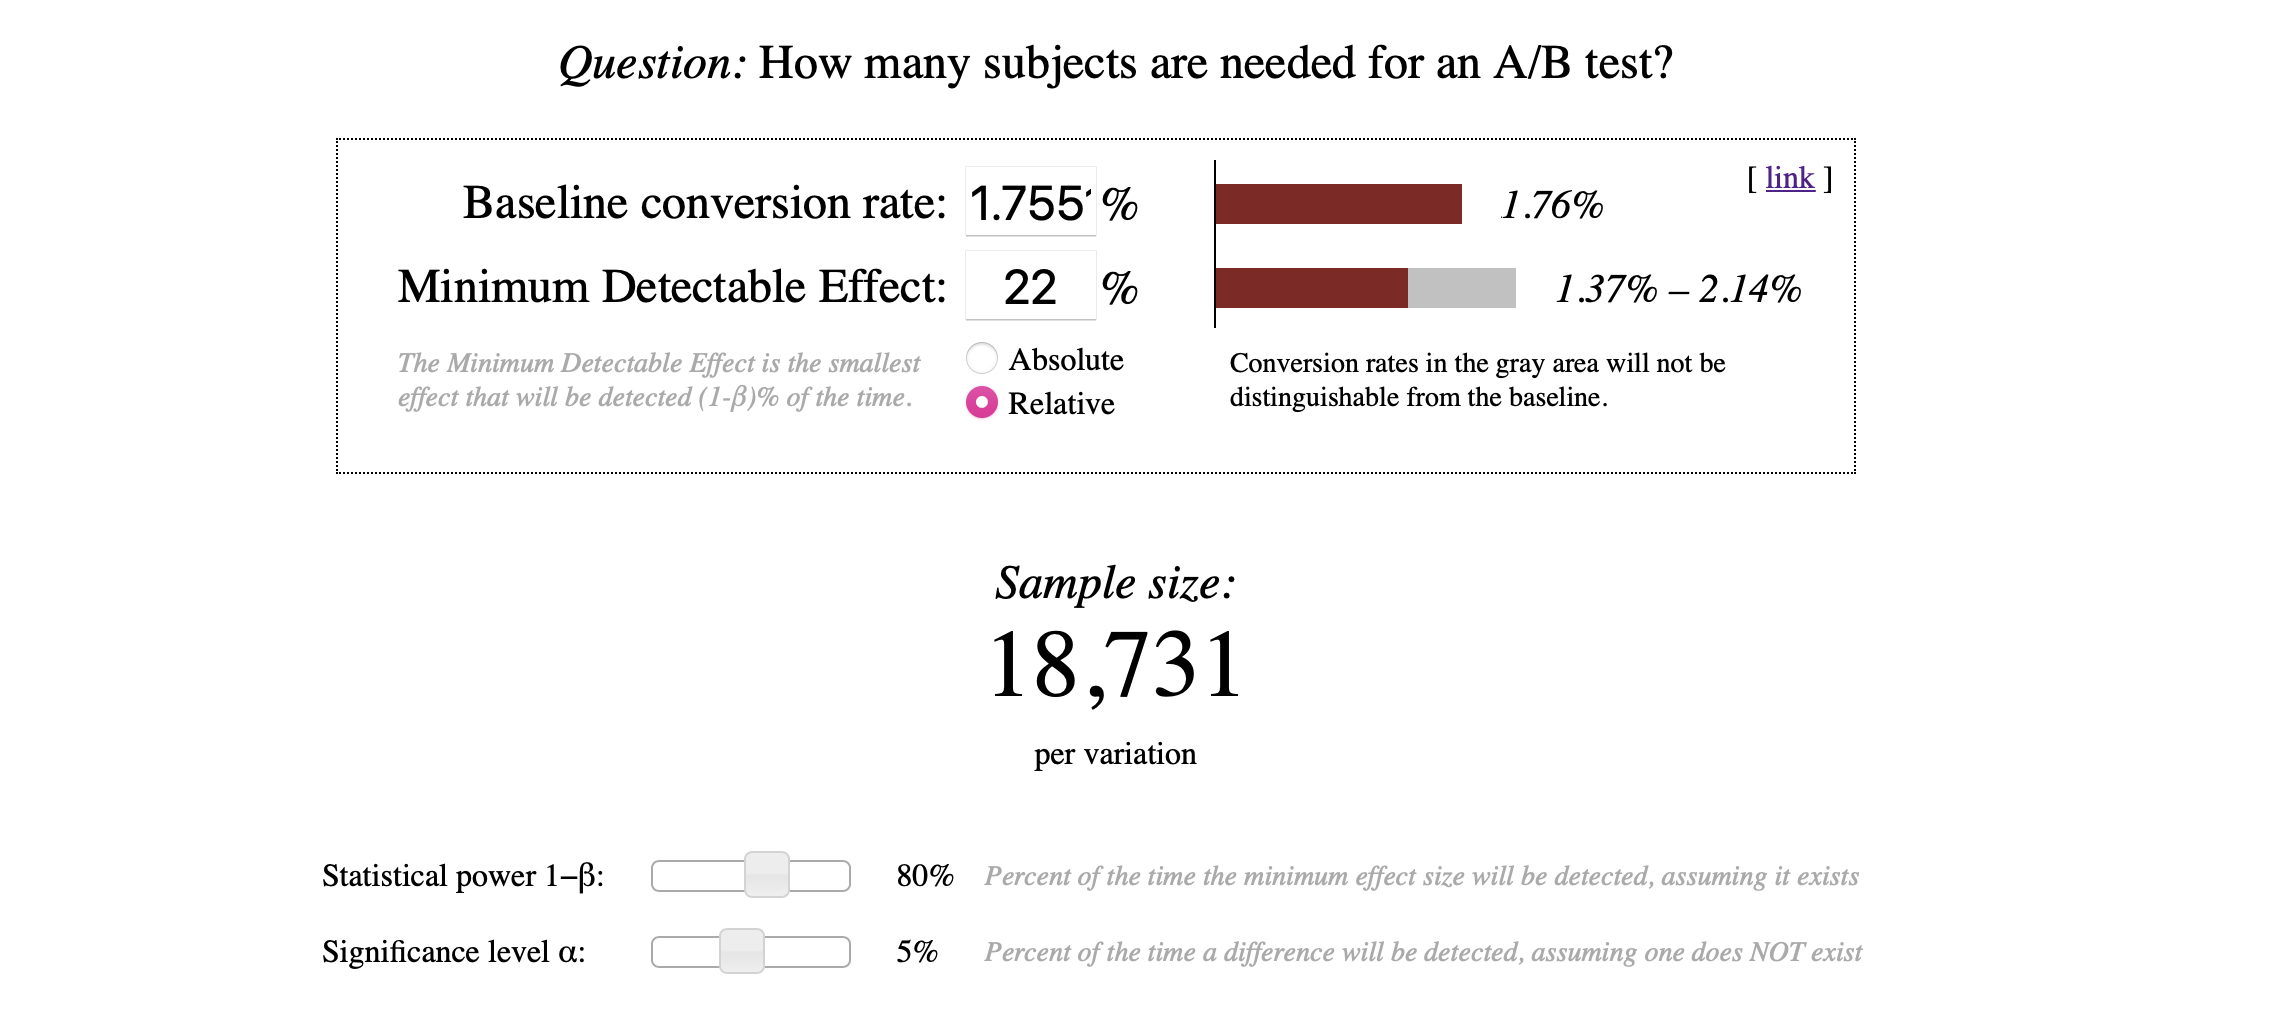

# Итог

In [385]:
print('Абсолютные показатели')
display(res_abs_T)
print('Относительные показатели')
display(res_relative)


Абсолютные показатели


var,control,variant
users,2390,2393
unl_users,2381,2388
%GT,49.968639,50.031361
unl_%GT,49.926609,50.073391
paying_users,54,42
unl_paying_users,45,37
revenue,470.56,179.32
unl_revenue,138.63,100.01


Относительные показатели


var,control,variant,%_delta
unl_ARPU,0.058223,0.04188,-28.069798
ARPU,0.196887,0.074935,-61.939988
unl_ARPPU,3.080667,2.702973,-12.260129
ARPPU,8.714074,4.269524,-51.004275
CR_order,2.259414,1.755119,-22.319729


<b>Вывод:</b> Гипотеза об увеличении дохода в тестовой группе не подтверждается. Наоборот, мы получили отрицательный эффект по всем метрикам, но для того, чтобы статистически подтвердить ухудшение нужно больше данных. 

unl_ означает что метрика посчитана без учета выбросов

- delta unl_ARPU = - 28% (не стат. значимо)
- delta unl_ARPPU = -12% (не стат. значимо)
- delta CR_order = -22% (не стат. значимо)




- Для достижения стат.значимости необходимо больше данных (как миниум по 18 700 в каждой группе). 
- Тем не менее, мы можем построить график с накопительным значенмем p-value по дням/неделям - если по мере увеличения количества данных наше p-value будет уменьшатся, то это верный признак того, что мы сможем подтвердить наличие отрицательного эффекта если бы у нас было еще больше данных. Дополнительно можно построить график с метриками в разрезе каждой группы и взглянуть на динамику - если показетли в тествой группе на протяжении всех периодов будут меньше чем в контрольной, то это дополнительный звонок о том, что различия на самом деле есть. 


